This notebook contains the results for why certain features are useful and our domain driven reasonining for the same

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

In [3]:
import statsmodels.api as sm
def decompose(df, freq=96):
    res = sm.tsa.seasonal_decompose(df.fillna(method='ffill').values, freq=freq)
    return pd.DataFrame({"seasonal":res.seasonal, "trend":res.trend, "obs":res.observed}, index=df.index)

In [4]:
df.describe()

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,fft_3,fft_4,fft_5,area,num_rooms,total_occupants,variance,ratio_min_max,difference_min_max,ratio_difference_min_max
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,56.000000,56.000000,52.000000,57.000000,57.000000,57.000000,57.000000
mean,0.176892,0.130971,0.157437,0.161640,0.244327,0.386957,0.408988,0.466611,0.358105,0.214525,...,0.289220,0.330489,0.365083,0.413337,0.523214,0.511538,0.278298,0.306204,0.364897,0.693796
std,0.143283,0.111858,0.127993,0.128915,0.158897,0.197405,0.197680,0.219006,0.172838,0.141379,...,0.203885,0.244299,0.235744,0.245703,0.271019,0.232340,0.216611,0.148126,0.160259,0.148126
min,0.015077,0.000000,0.010551,0.021189,0.039037,0.056366,0.052812,0.033859,0.070526,0.028826,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044657,0.000000
25%,0.087916,0.067750,0.064839,0.065353,0.125009,0.237471,0.258954,0.285738,0.204759,0.102634,...,0.121070,0.152489,0.141100,0.240059,0.300000,0.400000,0.110829,0.214667,0.246817,0.630155
50%,0.143181,0.100820,0.132612,0.143576,0.227986,0.351395,0.369211,0.475183,0.345546,0.173177,...,0.285969,0.238813,0.346670,0.409449,0.500000,0.400000,0.248380,0.313094,0.369336,0.686906
75%,0.202795,0.170097,0.211784,0.202044,0.316799,0.475664,0.514058,0.588675,0.465465,0.313125,...,0.394559,0.498695,0.526405,0.590059,0.725000,0.800000,0.387325,0.369845,0.455928,0.785333
max,0.928494,0.719195,0.736461,0.718856,0.772610,1.000000,0.936827,0.969289,0.862838,0.731150,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.770115,1.000000


In [5]:
import os
st = pd.HDFStore(os.path.expanduser("~/Downloads/wiki-temp.h5"))

In [6]:
dfs_hvac = {}
for home in all_homes['hvac']:
    temp = st['/%d' %home]['2013'][['use','air1']].resample("15T")
    decomposed_df = decompose(temp['use'], freq=96*7)
    dfs_hvac[home] = pd.DataFrame({"hvac":temp['air1'], 
                                   'use':temp['use'],
                                     'seasonal':decomposed_df.seasonal, 
                                     'seasonal-adj':decomposed_df.seasonal-decomposed_df.seasonal.min(),
                                     'trend':decomposed_df.trend})

In [30]:
from common_functions import latexify, format_axes

### The process of decomposition

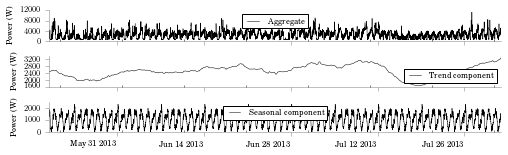

In [120]:
latexify(columns=2, fig_height=2.2)
d = dfs_hvac[370][['use','trend', 'seasonal-adj']]
d.columns = ['Aggregate','Trend component','Seasonal component']
ax = d['2013-05-20':].head(7000).plot(subplots=True,rot=0, linewidth=0.5)
plt.xlabel("")
for a in ax:
    a.set_ylabel("Power (W)")
    a.set_yticks(a.get_yticks()[::2])
    format_axes(a)
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/decomposition.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/decomposition.png",bbox_inches="tight")

### Seasonal component of aggregate matches HVAC

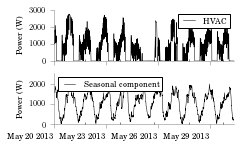

In [47]:
latexify()
ax = d['2013-05-20':][['HVAC','Seasonal component']].head(1000).plot(subplots=True,rot=0, linewidth=0.5)
plt.xlabel("")
for a in ax:
    a.set_ylabel("Power (W)")
    a.set_yticks(a.get_yticks()[::2])
    format_axes(a)
plt.tight_layout()
ax[1].set_xticks(a.get_xticks()[::3])
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/decomposition_hvac.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/decomposition_hvac.png",bbox_inches="tight")

### Homes similar on the seasonal component are similar in HVAC energy consumption

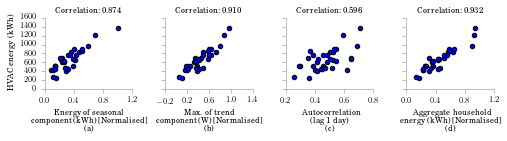

In [122]:
latexify(columns=2, fig_height=2.)
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True)
feature_name_map = {'max_seasonal_weekly':'Max. of seasonal \ncomponent (W) [Normalised]',
                   'seasonal_energy_7':'Energy of seasonal \ncomponent (kWh) [Normalised]',
                   'max_trend_weekly':'Max. of trend \ncomponent (W) [Normalised]',
                   'autocorr':'Autocorrelation \n(lag 1 day)',
                   'aggregate_7':'Aggregate household \n energy (kWh) [Normalised]'}
alphabets = "abcdefgh"
for i, feature_name in enumerate(['seasonal_energy_7',
                                  'max_trend_weekly','autocorr','aggregate_7']):
    e = df.ix[all_homes["hvac"]][['hvac_7',feature_name]]
    c = e.corr().values[0,1]
    e.columns = ['HVAC energy (kWh)',feature_name_map[feature_name]+"\n("+alphabets[i]+")"]
    e.plot(kind="scatter",y=e.columns[0],x=e.columns[1],ax=ax[i], color='k')
    ax[i].set_xticks(ax[i].get_xticks()[::2])
    format_axes(ax[i])
    ax[i].set_title("Correlation: %0.3f" %c)
ax[1].set_ylabel("")
ax[2].set_ylabel("")
ax[3].set_ylabel("")
#ax[4].set_ylabel("")

plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/hvac_features.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/hvac_features.png",bbox_inches="tight")

In [50]:
df_appl = {appliance:df.ix[all_homes[appliance]] for appliance in all_homes.keys()}

In [48]:
def plot_correlations(df, appliance, feature):
    months = ["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    if appliance is not "hvac":
        fig, ax = plt.subplots(ncols=6, nrows=2, sharey=True, sharex=True, figsize=(16,6))
        for month in range(1, 13):
            ax[(month-1)/6, (month-1)%6].scatter(df[feature],df['%s_%d' %(appliance, month)])
            ax[(month-1)/6, (month-1)%6].set_title(df[[feature, '%s_%d' %(appliance, month)]].corr().values[0, 1])
            ax[(month-1)/6, (month-1)%6].set_xlabel(months[month-1])
        ax[0,0].set_ylabel("Energy (kWh)")
        ax[1,0].set_ylabel("Energy (kWh)")
    else:
        fig, ax = plt.subplots(ncols=6, nrows=1, sharey=True, sharex=True, figsize=(16,3))
        for month in range(5, 11):
            ax[month-5].scatter(df[feature],df['%s_%d' %(appliance, month)])
            ax[month-5].set_title(df[[feature, '%s_%d' %(appliance, month)]].corr().values[0, 1])
            ax[month-5].set_xlabel(months[month-1])
        ax[0].set_ylabel("Energy (kWh)")
    plt.tight_layout()

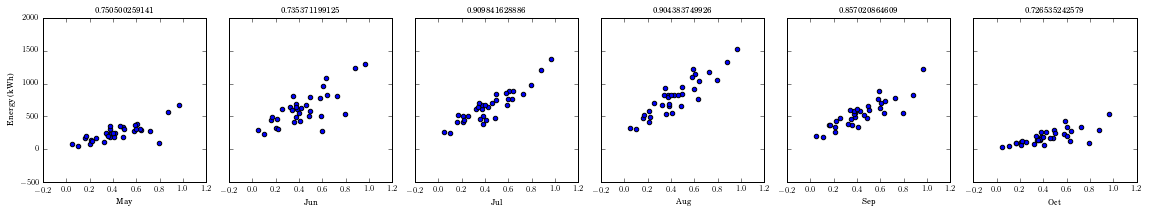

In [82]:
appliance="hvac"
feature='max_trend_weekly'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

In [66]:
%matplotlib inline

In [5]:
df_appl = {appl:df.ix[all_homes[appl]].copy() for appl in ['fridge','hvac','dr','light','dw','wm']}

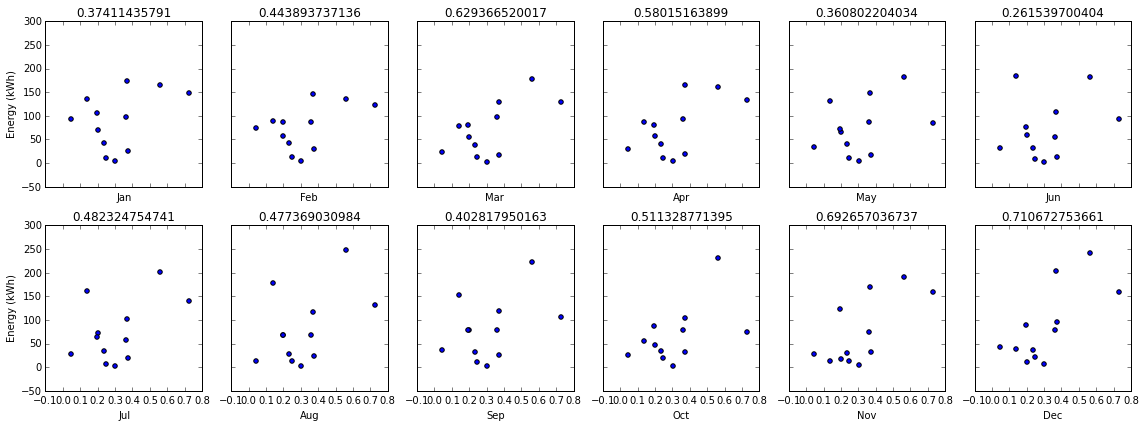

In [27]:
appliance="light"
feature='difference_min_max'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

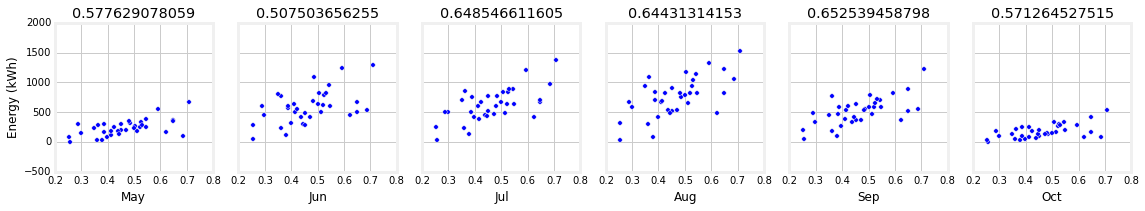

In [191]:
appliance="hvac"
feature='autocorr'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(16, 6))
dfs_hvac[370]['trend'][:].plot(ax=ax,label="370")
dfs_hvac[94]['trend'][:].plot(ax=ax, label="94")
dfs_hvac[2814]['trend'][:].plot(ax=ax, label="2814")
dfs_hvac[3367]['trend'][:].plot(ax=ax, label="3367")

plt.legend()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_trend.png", bbox_inches="tight")
plt.xlabel("")

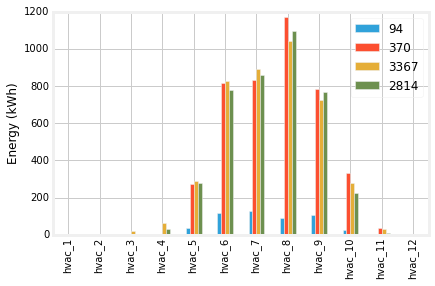

In [243]:
df_appl["hvac"].ix[[94, 370, 3367, 2814]][['hvac_%d' %i for i in range(1, 13)]].T.plot(kind="bar")
plt.ylabel("Energy (kWh)")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_trend_gt.png")

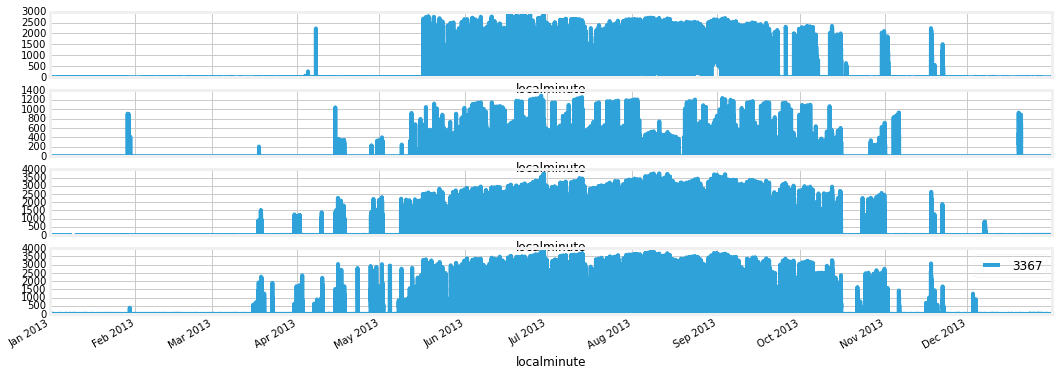

In [235]:
fig, ax = plt.subplots(sharex=True, nrows=4, figsize=(16,6))
dfs_hvac[370]['hvac'][:].plot(ax=ax[0],label="370")
dfs_hvac[94]['hvac'][:].plot(ax=ax[1], label="94")
dfs_hvac[2814]['hvac'][:].plot(ax=ax[2], label="2814")
dfs_hvac[3367]['hvac'][:].plot(ax=ax[3], label="3367")


plt.legend()

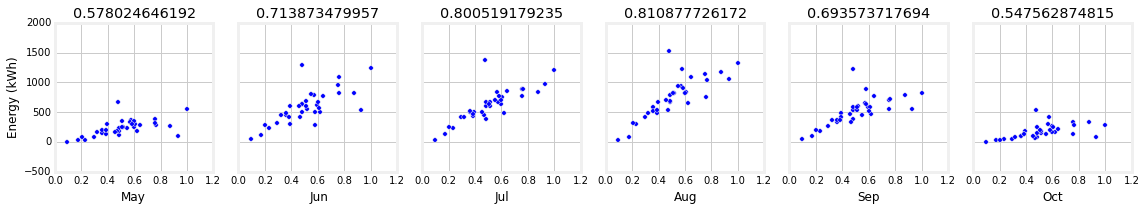

In [195]:
appliance="hvac"
feature='stdev_trend_weekly'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

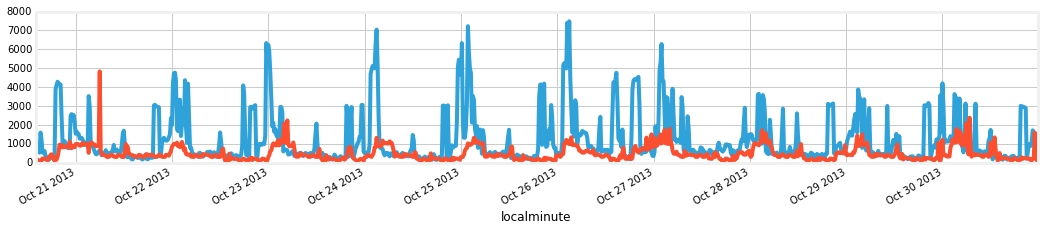

In [194]:
st['/26']['2013-05-01':'2013-10-30']['use'].resample("15T").tail(1000).plot(figsize=(16,3))
st['/94']['2013-05-01':'2013-10-30']['use'].resample("15T").tail(1000).plot(figsize=(16,3))



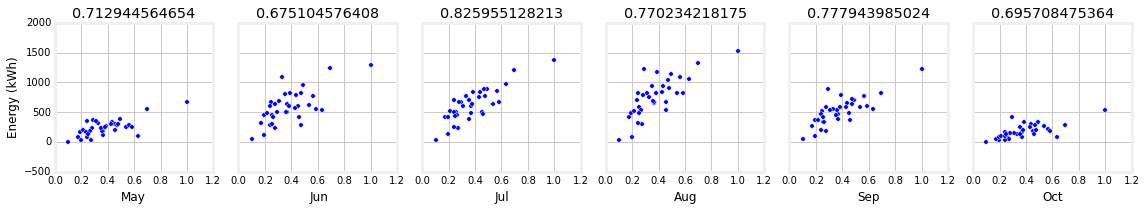

In [141]:
plot_correlations(df_appl['hvac'], 'hvac', 'stdev_seasonal_weekly')

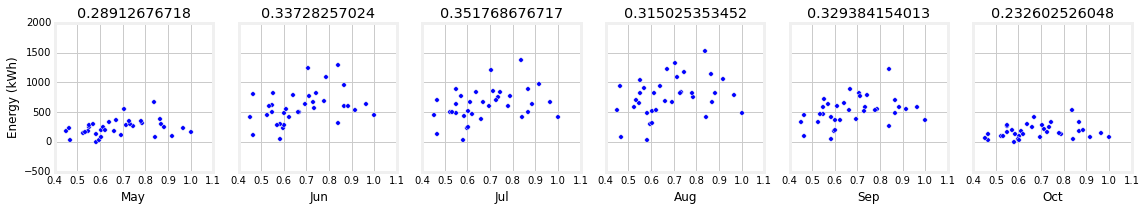

In [158]:
plot_correlations(df_appl['hvac'], 'hvac', 'temperature_corr')